### 1) Initial Imports and loading the utils function. The dataset is used is <a href='https://www.kaggle.com/adityajn105/flickr8k'>Flickr 8k</a> from kaggle.<br>Custom dataset and dataloader is implemented in <a href="https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k">this</a> notebook.

In [1]:
#location of the training data 
data_location =  "dataset/flickr8k"
#copy dataloader
# !cp ../input/data-loader/data_loader.py .

#imports
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

#custom imports 
from dataset.data_loader import FlickrDataset, get_data_loader
import pandas as pd

### 2) **<b>Implementing the Helper function to plot the Tensor image**

In [2]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    # img[0] = img[0] * 0.229
    # img[1] = img[1] * 0.224 
    # img[2] = img[2] * 0.225 
    # img[0] += 0.485 
    # img[1] += 0.456 
    # img[2] += 0.406
    
    img = img.cpu().numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
#Initiate the Dataset and Dataloader

#setting the constants
data_location =  "dataset/flickr8k"
data_location_30 =  "dataset/flickr30k_images"
BATCH_SIZE = 64
# BATCH_SIZE = 6
NUM_WORKER = 16

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(256),
    T.RandomCrop(256),
    T.ToTensor(),
    # T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    caption_file = data_location+"/captions.txt",
    transform=transforms
)

dataset30 =  FlickrDataset(
    root_dir = data_location_30+"/flickr30k_images",
    caption_file = data_location_30+"/results.csv",
    transform=transforms,
    sep = "\| "
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
)

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/vvh413/.local/lib/python3.10/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


device(type='cuda', index=0)

### 3) Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from compress import HyperpriorWrapper

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_channels=192, enc_hidden=512, encoder_dim=2048, feature_size=7):
        super(Encoder, self).__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(in_channels, enc_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(enc_hidden),
            nn.ReLU(),
            nn.Conv2d(enc_hidden, enc_hidden*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(enc_hidden*2),
            nn.ReLU(),
            nn.Conv2d(enc_hidden*2, encoder_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(encoder_dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((feature_size, feature_size)),
        )
        
    def forward(self, image_vectors):
        image_vectors = self.enc(image_vectors) #(batch_size,2048,7,7)
        image_vectors = image_vectors.permute(0, 2, 3, 1) #(batch_size,7,7,2048)
        image_vectors = image_vectors.view(image_vectors.size(0), -1, image_vectors.size(-1)) #(batch_size,49,2048)
        return image_vectors


In [6]:
class EncoderResNet(nn.Module):
    def __init__(self):
        super(EncoderResNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [7]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        

In [8]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [9]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim, enc_hidden, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = Encoder(
            enc_hidden=enc_hidden, 
            encoder_dim=encoder_dim
        )
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


In [10]:
class EncoderDecoderResNet(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderResNet()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

### 4) Setting Hypperparameter and Init the model

In [11]:
#Hyperparams
resnet_hyperparams = dict(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512,
)

compressin_hyperparams = dict(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    enc_hidden=256,
    encoder_dim=2048,
    decoder_dim=512,
)

learning_rate = 3e-4

In [12]:
#init model
model_resnet = EncoderDecoderResNet(**resnet_hyperparams).to(device)
model_compression = EncoderDecoder(**compressin_hyperparams).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model_compression.parameters(), lr=learning_rate)

In [13]:
#helper function to save the model
def save_model(model, params, num_epochs, path):
    model_state = {
        'num_epochs':num_epochs,
        **params,
        'state_dict':model.state_dict()
    }

    torch.save(model_state, path)

In [14]:
compressor = HyperpriorWrapper(1, pretrained=True).eval().to(device)

In [15]:
@torch.no_grad()
def compress(x, co):
    return co.encode(x)
    # compressed = co.compress(x)
    # return co.entropy_decode(compressed["strings"], compressed["shape"])


@torch.no_grad()
def decompress(y, co):
    return co.decode(y)

In [16]:
def param_amount(model):
    return sum(p.numel() for p in model.parameters())

In [17]:
param_amount(model_resnet)

35608459

In [18]:
param_amount(model_resnet) / param_amount(model_compression) #+ param_amount(compressor.model)

1.5369623501305136

In [24]:
from torchinfo import summary

summary(model_compression)

Layer (type:depth-idx)                   Param #
EncoderDecoder                           --
├─Encoder: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  442,624
│    │    └─BatchNorm2d: 3-2             512
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  1,180,160
│    │    └─BatchNorm2d: 3-5             1,024
│    │    └─ReLU: 3-6                    --
│    │    └─Conv2d: 3-7                  9,439,232
│    │    └─BatchNorm2d: 3-8             4,096
│    │    └─ReLU: 3-9                    --
│    │    └─AdaptiveAvgPool2d: 3-10      --
├─DecoderRNN: 1-2                        --
│    └─Embedding: 2-2                    898,200
│    └─Attention: 2-3                    --
│    │    └─Linear: 3-11                 131,328
│    │    └─Linear: 3-12                 524,544
│    │    └─Linear: 3-13                 257
│    └─Linear: 2-4                       1,049,088
│    └─Linear: 2-5    

## 5) Training Job from above configs

In [60]:
from tqdm.notebook import tqdm

In [61]:
scaler = torch.cuda.amp.GradScaler()

Epoch: 1 loss: 0.00000:   0%|          | 0/633 [00:00<?, ?it/s]

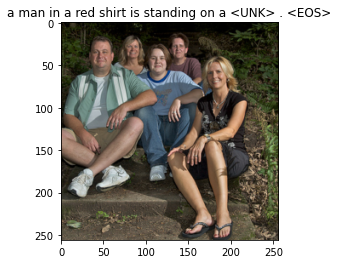

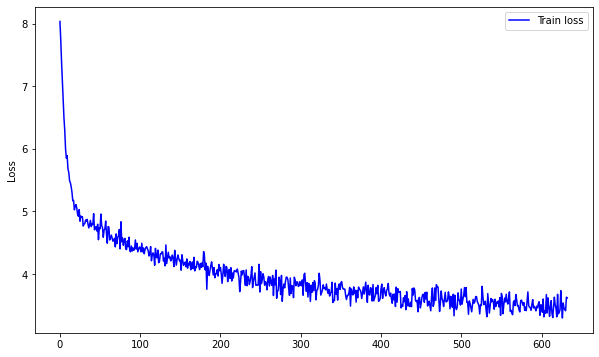

Epoch: 2 loss: 0.00000:   0%|          | 0/633 [00:00<?, ?it/s]

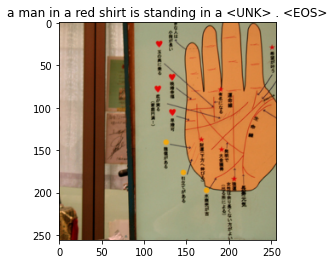

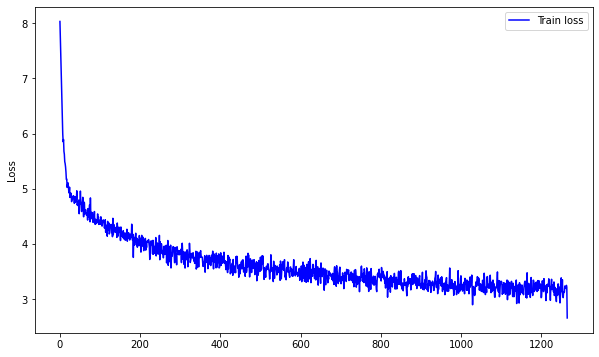

Epoch: 3 loss: 0.00000:   0%|          | 0/633 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13a9f8a3b0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13a9f8a3b0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessi

KeyboardInterrupt: 

In [62]:
num_epochs = 25
print_every = 100

train_losses = []

for epoch in range(1, num_epochs+1):
    
    progress = tqdm(enumerate(data_loader), total=len(data_loader), desc="Epoch: {} loss: {:.5f}".format(epoch, 0))
    for idx, (image, captions) in progress:
        image,captions = image.to(device),captions.to(device)

        
        with torch.cuda.amp.autocast():
            image = compress(image, compressor)
            outputs, attentions = model_compression(image, captions)
            targets = captions[:,1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        progress.set_description("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
        train_losses.append(loss.item())


    model_compression.eval()
    with torch.no_grad():
        dataiter = iter(data_loader)
        img,_ = next(dataiter)
        compressed = compress(img[0:1].to(device), compressor)
        features = model_compression.encoder(compressed)
        caps,alphas = model_compression.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(img[0],title=caption)

    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train loss", color="blue")
    # plt.plot(val_losses, label="Val loss", color="orange")
    # plt.axhline(y=2, color="gray", linestyle="--", label="Target loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.show()

    model_compression.train()
        
    #save the latest model
    save_model(model_compression, compressin_hyperparams, epoch, f'checkpoints/compression_model_state_3conv_256h/{epoch:03}.pth')

## 6 Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [25]:
def load_model(model, checkpoint):
    state_dict = torch.load(checkpoint)["state_dict"]
    model.load_state_dict(state_dict)

In [26]:
load_model(model_compression, f'checkpoints/compression_best_md.pth')
load_model(model_resnet, f'attention_model_state.pth')

In [27]:
norm = T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))

trf = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    # T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

def unnorm(img):
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    return img

In [28]:
#generate caption
def get_caps_from(model, image):
    #generate the caption
    model.eval()
    with torch.no_grad():
        if isinstance(model, EncoderDecoder):
            image = compressor.encode(image)
            # features_tensors = compressor.entropy_decode(compressed["strings"], compressed["shape"])
        else:
            image = trf(image)
        features = model.encoder(image)
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    caption = ' '.join(result)
    show_image(img,title=caption)

    img = img.cpu().numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7, 7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

In [33]:
import random

Two hikers rest on a snow-covered mountain .


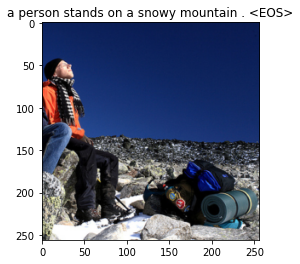

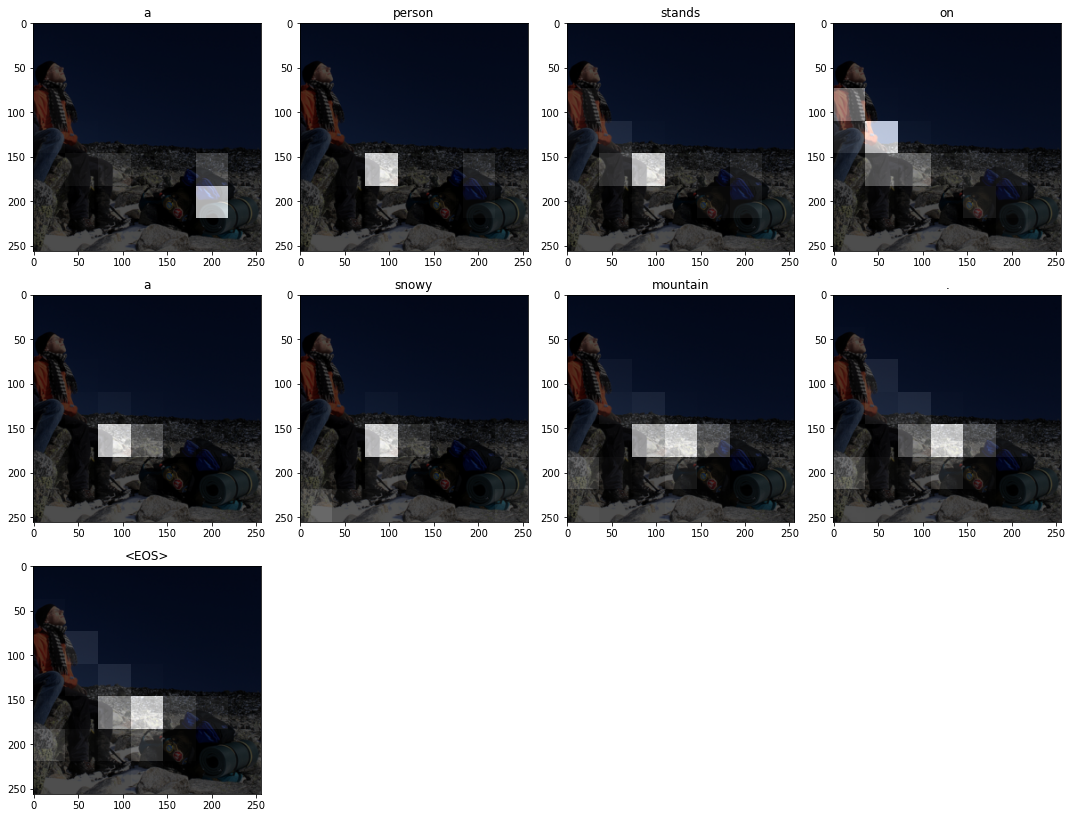

In [55]:
#show any 1
idx = random.randint(0, len(dataset30)-1)
images, tokens = dataset30[idx]
capt = dataset30.captions[idx]
images = images.to(device)[None]

img = images[0].detach().clone().to(device)
img1 = images[0].detach().clone().to(device)

caps, alphas = get_caps_from(model_compression, img.unsqueeze(0))

print(capt)
plot_attention(img1, caps, alphas)

In [48]:
import spacy
import random

In [49]:
nlp = spacy.load('en_core_web_md')

Fit brunette enjoys some time rock climbing .
tensor([   1,    3, 1609,  615,  149,  880,   33,   32,    5,    2])


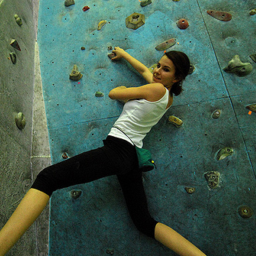

In [50]:
idx = random.randint(0, len(dataset)-1)
image, tokens = dataset[idx]
capt = dataset.captions[idx]
image = image.to(device)
print(capt)
print(tokens)
T.ToPILImage()(image)

In [51]:
caps, alphas = get_caps_from(model_compression, image.unsqueeze(0))
caption = " ".join(caps)
caption

'a girl in a green bathing suit is climbing a rock wall . <EOS>'

In [52]:
nlp(capt).similarity(nlp(caption))

0.8290230147679205

In [53]:
def similarity(s1, s2):
    return nlp(s1).similarity(nlp(s2))

In [54]:
from tqdm.notebook import tqdm
import random

In [71]:
sim_resnet = []
sim_compression = []
for _ in tqdm(range(1000)):
    idx = random.randint(0, len(dataset30)-1)
    image, tokens = dataset30[idx]
    image = image.to(device)
    capt = dataset30.captions[idx]
    pred_resnet = " ".join(get_caps_from(model_resnet, image.unsqueeze(0))[0])
    pred_compression = " ".join(get_caps_from(model_compression, image.unsqueeze(0))[0])
    sim_resnet.append(similarity(capt, pred_resnet))
    sim_compression.append(similarity(capt, pred_compression))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [74]:
sim = {"resnet": sim_resnet, "compression":sim_compression}

In [75]:
# sim["sim_compression_md"] = sim_compression_md
sim.keys()

dict_keys(['resnet', 'compression'])

In [76]:
torch.save(sim, "similarities")

In [77]:
sim = torch.load("similarities")

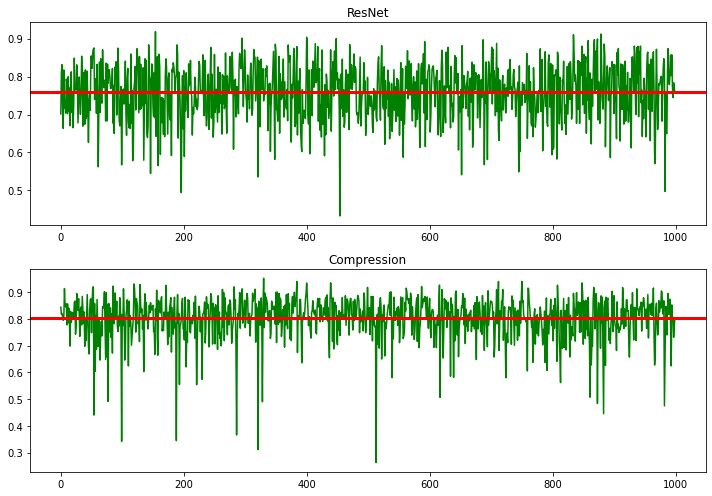

In [84]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(sim["resnet"], color="g")
plt.axhline(y=np.mean(sim["resnet"]), linewidth=3, color="r")
plt.title("ResNet")
plt.subplot(2, 1, 2)
plt.plot(sim["compression"], color="g")
plt.axhline(y=np.mean(sim["compression"]), linewidth=3, color="r")
plt.title("Compression")
plt.tight_layout()
plt.show()

In [80]:
np.mean(sim["resnet"]), np.mean(sim["compression"])

(0.7585230864181012, 0.8030362753747898)

In [66]:
def run(model, n=1000):
    model.eval()
    with torch.no_grad():
        for _ in tqdm(range(n)):
            idx = random.randint(0, len(dataset)-1)
            image, tokens = dataset[idx]
            capt = dataset.captions[idx]
            image = image.to(device)[None]
            
            with torch.cuda.amp.autocast():
                if isinstance(model, EncoderDecoder):
                    image = compressor.encode(image)
                else:
                    image = trf(image)
                features = model.encoder(image)
                caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

In [88]:
run(model_resnet)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [89]:
run(model_compression)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [90]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

TypeError: get_caps_from() missing 1 required positional argument: 'image'

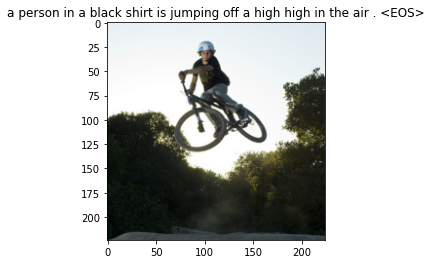

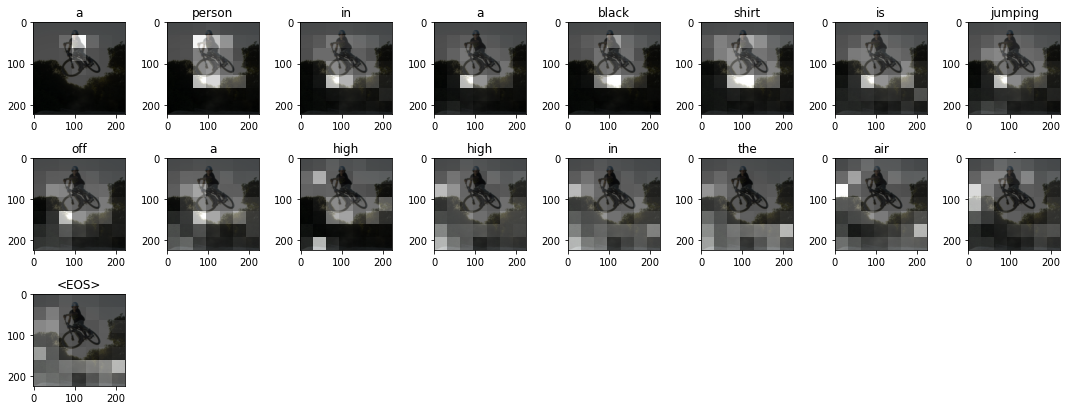

In [58]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

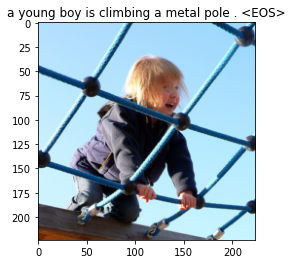

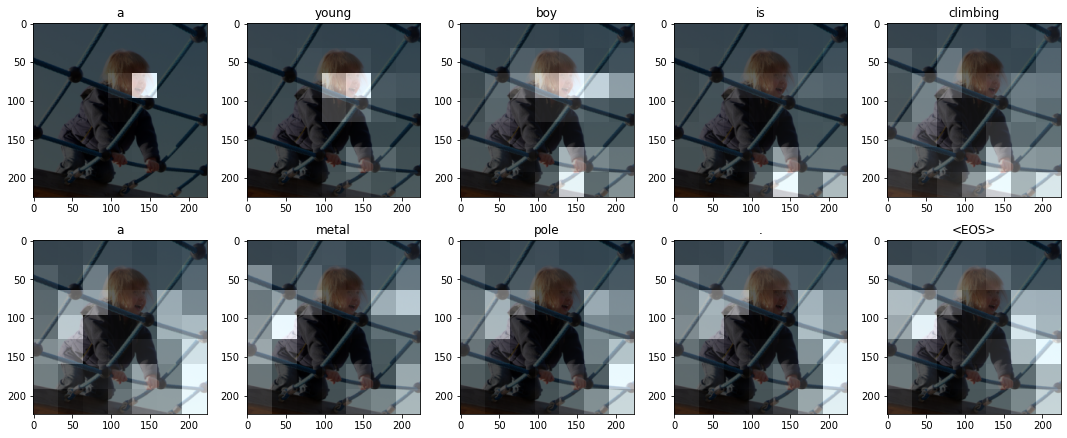

In [62]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)